<center> <h1> Article 1 - Implementation de Faster RCNN </h1> </center>

Ceci est la deuxiéme approche pour l'implémentation de Faster RCNN que nous avons mentionée dans l'article :

### Différents imports nécessaires :

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
%matplotlib inline
import matplotlib.pyplot as pl
from PIL import Image
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util

Pour que ça fonctionne, il faut impérativement que la version tensorflow-gpu doit être supérieur à 1.12.0.

In [2]:
if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

------------------------------------------------------------------------------------------

### Le modéle : 

#### Initialisation :

Le modéle que nous utiliserons est un modéle que tensorflow propose pour éviter tout calcul nécessaire d'entrainement du modéle.

La liste des différents modéles se trouve sur ce [lien](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

Une fois sur le lien, il existe un tableau en bas de page avec les différents noms de modéles, ainsi que le temps qu'ils prennent pour donner des résultats et leurs accuracy.

In [3]:
# Ici, on met le nom du modéle à télécharger
MODEL_NAME = 'faster_rcnn_resnet101_coco_2017_11_08'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
# En effet, le lien dont on a télechargé le modéle, c'est le lien que tensorflow propose pour le télechargements 
# des différents modéles pré-entrainés tels que, Faster RCNN, Mask RCNN, SSD, YOLO, etc...

PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# La liste des labels
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

### Télechargement du modéle :

In [4]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

### Chargement du modéle : 

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Chargement du label map

Les labels mappent les indices sur les noms de catégories, de sorte que lorsque notre réseau de convolution prédit «5», nous savons que cela correspond à «avion». 

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Fonction de conversion :

Cette fonction est utile pour changer la taille de l'image, et la transformer d'une image, à un tableau numpy, de façon à ce que ça soit compréhensible par le modéle. 

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

### Les images sur lesquelles nous ferons la prédiction :

In [8]:
# Les différents images sont dans le dossier test_images.
PATH_TO_TEST_IMAGES_DIR = 'test_images'

# Nous avons 3 images à tester :
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Taille de l'image de sortie.
IMAGE_SIZE = (12, 8)

In [9]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # Ce preprocessing ce fait image par image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe est important pour translater les mask du box coordinates au image coordinates
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
      
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Running
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # Les différents outputs sont des float numpy array. 
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

test_images\image1.jpg
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=636x359 at 0x1418FCC6FD0>
test_images\image2.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x14193241400>
test_images\image3.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1352x900 at 0x14193245CF8>


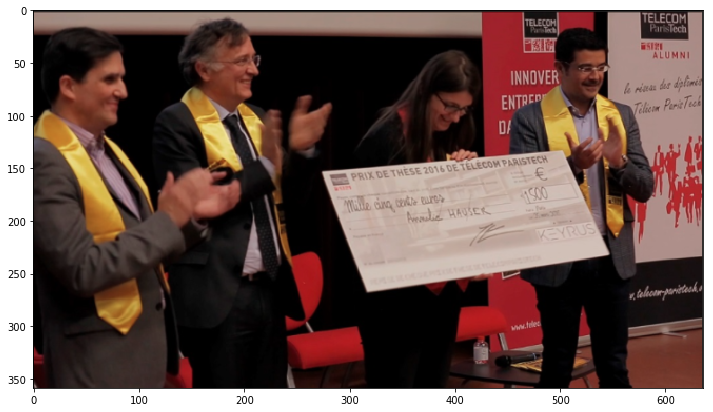

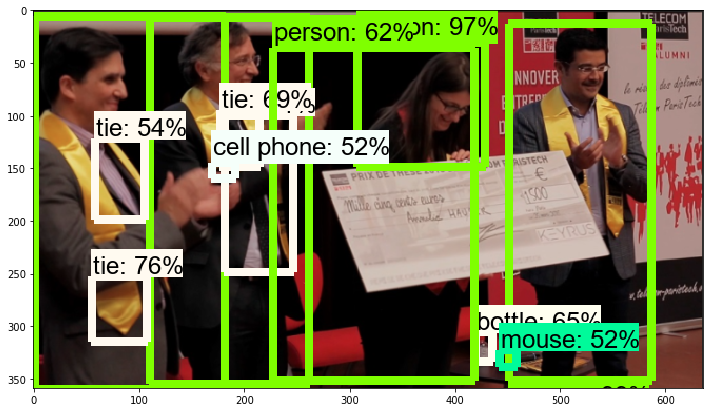

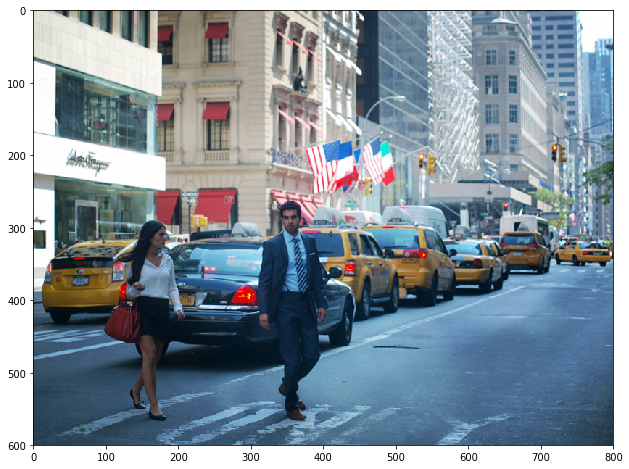

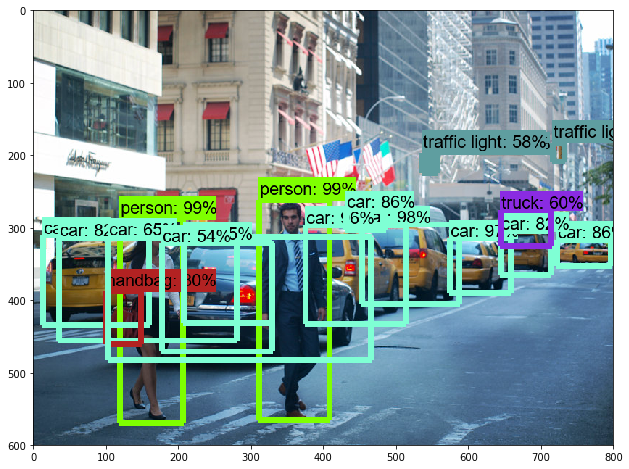

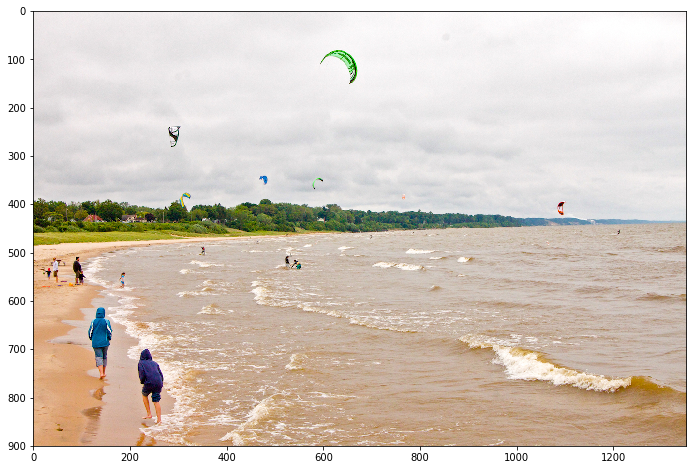

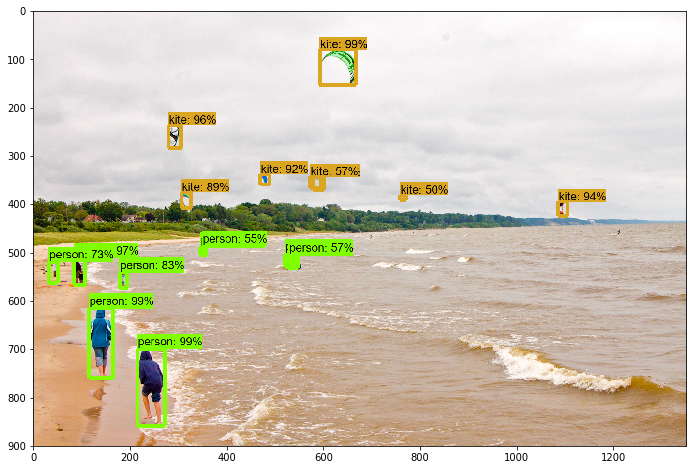

In [10]:
for image_path in TEST_IMAGE_PATHS:
    print(image_path)
    image = Image.open(image_path)
    pl.figure(figsize=IMAGE_SIZE)
    print(image)
    pl.imshow(image)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    # La représentation de l'image basée sur un tableau numpy sera utilisée ultérieurement afin de préparer l'image
    # résultatante avec des carrés et des labels sur elle.
    image_np = load_image_into_numpy_array(image)
    # Expansion des dimensions puisque le modéle attend des images avec une taille de : [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # La détection
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # La visualisation des résultats
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    pl.figure(figsize=IMAGE_SIZE)
    pl.imshow(image_np)